## Analyzing Real and AI Generated Image with Fast Fourier Transform

The goal of this experiment is to analyze the differences between Real and Fake images when they are processed by Fast Fourier Transform. To make this analysis possible, we need to process real and fake images with fourier transform; then, the outputs need to be processed with a Radial Integral Operation so that they are reduced to a single dimension. 

For visualization, let us use dimensionality reduction and view the features. 

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle

In [2]:
# Functio
def fft_ybr(image: np.ndarray, channel: str = 'Y') -> np.ndarray:
    """
    Convert image to YBR color space and perform FFT on the specified channel.
    Parameters:
        image: Input image (BGR format assumed)
        channel: 'Y', 'B', or 'R' to specify which channel to transform
    Returns
        Fourier-transformed image
    """
    # Convert to YCrCb color space (Y, Cb, Cr are equivalent to Y, B, R)
    ybr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    
    # Select the channel
    channel_map = {'Y': 0, 'B': 1, 'R': 2}
    if channel not in channel_map:
        raise ValueError("Channel must be one of 'Y', 'B', or 'R'")
    
    selected_channel = ybr[:, :, channel_map[channel]]
    
    # Perform FFT and shift zero-frequency component to center
    fft_image = np.fft.fftshift(np.fft.fft2(selected_channel))
    return fft_image

In [3]:
def rio_fft(fft_image: np.ndarray, scale: str = 'log') -> np.ndarray:
    """
    Apply Radial Integral Operation (RIO) on the Fourier-transformed image.
    Parameters:
        fft_image: Input FFT image (2D complex array)
        scale: 'log' for logarithmic radius steps, 'linear' for uniform steps
    Returns:
        rio_vector: RIO processed vector
    """
    h, w = fft_image.shape
    cy, cx = h // 2, w // 2  # Center coordinates
    
    # Create radius map
    # Creating arrays with the pixel indices
    y, x = np.indices((h, w))
    # Distance from the center pixel
    r = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
    
    # Define radial bins
    if scale == 'log':
        radii = np.logspace(0, np.log10(np.max(r)), num=50)
    else:  # Linear
        radii = np.linspace(0, np.max(r), num=50)
    
    rio_vector = np.zeros(49, dtype=np.float32)
    
    # Compute radial integral
    for i in range(len(radii) - 1):
        mask = (r >= radii[i]) & (r < radii[i + 1])
        # Absolute is taken so that we focus only on the value component
        rio_vector[i] = np.abs(fft_image[mask]).sum()
    
    
    return rio_vector

In [4]:
def visualize_fft(fft_image: np.ndarray):
    """
    Visualize the magnitude spectrum of the FFT image.
    Parameters:
        fft_image: Input FFT image (2D complex array)
    """
    magnitude_spectrum = np.log1p(np.abs(fft_image))
    plt.figure(figsize=(6, 6))
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title("FFT Magnitude Spectrum")
    plt.colorbar()
    plt.show()

### Sample visualization

In [5]:
# Loading random Image
path = "/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data"
trainset = os.listdir(path)
print("Number of training images: ", len(trainset))

Number of training images:  79950


In [6]:
rand_img = Image.open(os.path.join(path, trainset[0]))
rand_img.show()

In [ ]:
# Converting to Fourier
fft_img = fft_ybr(image = np.array(rand_img), channel = "Y")

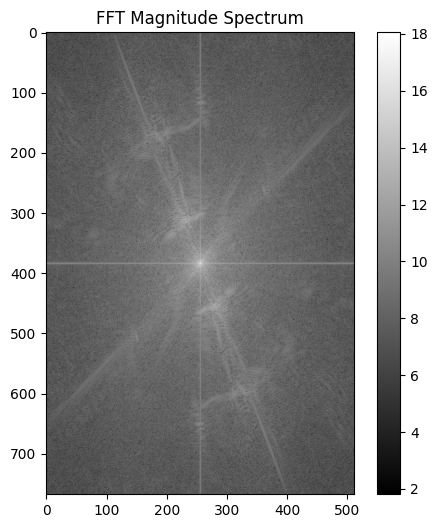

In [ ]:
visualize_fft(fft_img)

In [ ]:
rio_output = rio_fft(fft_img, "linear")

In [ ]:
print("Shape of rio output: ", rio_output.shape)

Shape of rio output:  (49,)


### Experiments

#### Data Preprocessing:

Creating X and Y Data

In [7]:
# Working on the images from the csv file
import pandas as pd

In [8]:
# Path to directory
source_path = ""

In [9]:
# Loading csv file and creating X and Y
csv_path = os.path.join(source_path, "train.csv")
dataframe = pd.read_csv(csv_path)
print(dataframe)

       Unnamed: 0                                        file_name  label
0               0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1               1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2               2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3               3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4               4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
...           ...                                              ...    ...
79945       79945  train_data/9283b107f6274279b6f15bbe77c523aa.jpg      0
79946       79946  train_data/4c6b17fe6dd743428a45773135a10508.jpg      1
79947       79947  train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg      0
79948       79948  train_data/ff960b55f296445abb3c5f304b52e104.jpg      1
79949       79949  train_data/3abd1876472f4ec988aa78f76664fbd6.jpg      0

[79950 rows x 3 columns]


In [10]:
# Creating list with image paths
img_paths = [os.path.join(source_path, i) for i in dataframe["file_name"]]
print("Sample Image path: ",img_paths[0])

Sample Image path:  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg


In [11]:
# Length of dataset
dataset_size = len(img_paths)

In [12]:
# GT labels - Y
Y = np.array(dataframe["label"])[:dataset_size]
print(Y.shape)

(79950,)


In [ ]:
# Split of dataset: How many Real and Fake classes
unique_counts = np.bincount(Y)
print("Counts of each class: ", unique_counts)

Counts of each class:  [39975 39975]


In [ ]:
# Training Feature - X
X = np.zeros((49, dataset_size))
for i in range(dataset_size):
    # Loading img
    img = cv2.imread(img_paths[i], cv2.IMREAD_COLOR)
    # Focusing on Y channel FFT
    fft_img = fft_ybr(np.array(img), "Y")
    # RIO
    rio_img = rio_fft(fft_img, "linear")
    X[:, i] = rio_img

print("Shape of X: ", X.shape)

Shape of X:  (49, 79950)


In [ ]:
X = np.transpose(X)
print("Shape of X: ", X.shape)

Shape of X:  (79950, 49)


In [ ]:
# Saving X data to prevent reloading
np.save("X_complete.npy", X)

#### Visualization

The most prudent way to get into modelling is to first visualize what you are working with. First, I am going to start with a vanilla PCA. 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# 2 dimensional visualization
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

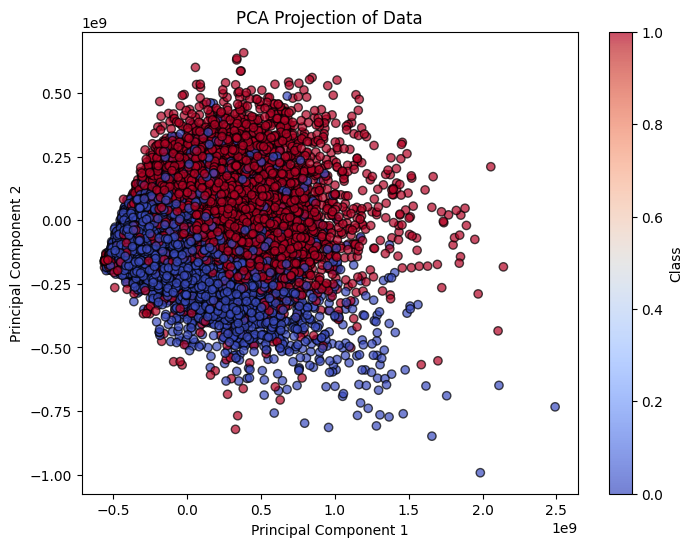

In [ ]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Data")
plt.colorbar(label="Class")
plt.show()

**From a cursory look, it does look like a linear separation might work; but lets try a more robust visualization - t-SNE**

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

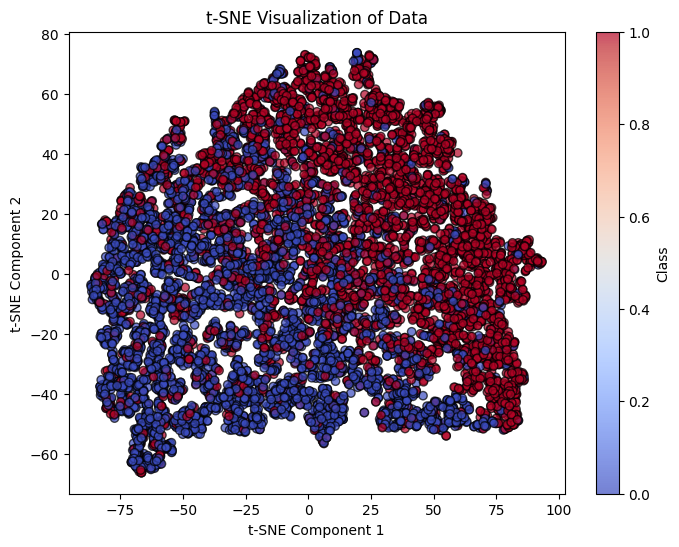

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization of Data")
plt.colorbar(label="Class")
plt.show()

**There are multiple overlaps, which isn't highly encouraging**

#### Linearity Testing

Before getting into anything complicated, let us first test if the data is linearly separable, with simple logistic regression

Process flow:

    1. Loading the feature matrix for the entire dataset
    2. Creating a train-val-test split using sklearn
    3. Cross validation to find the best-parameters -- TODO
    4. Visualize the result on the test set.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
X = np.load("X_complete.npy")
#X = np.transpose(X)

In [ ]:
print("Shape of input: ", X.shape)

Shape of input:  (79950, 49)


In [ ]:
# Splitting into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
# Label distribution in train and test
train_dist = np.bincount(y_train)
test_dist = np.bincount(y_test)
print("Train dist: ", train_dist)
print("Test dist: ", test_dist)

Train dist:  [31991 31969]
Test dist:  [7984 8006]


In [ ]:
model = LogisticRegression(solver = "liblinear")
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [ ]:
train_prediction = model.predict(X_train)
print("Accuracy: ", accuracy_score(y_train, train_prediction))

Accuracy:  0.816166353971232


In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8222013758599125


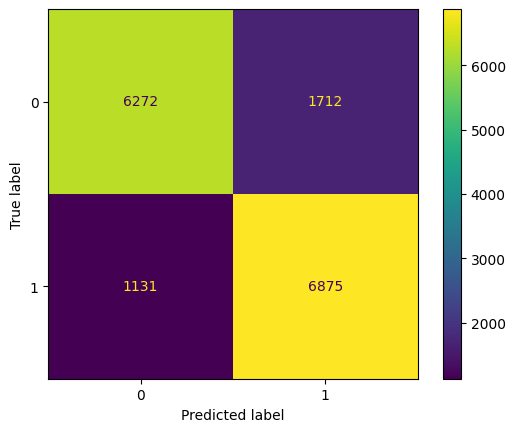

In [ ]:
cm_test = confusion_matrix(y_test, y_pred, labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp.plot()
plt.show()

**Given that this seems encouraging, let us try using the same model for submission: 0.7 F score**

In [ ]:
# Saving linear model
with open("logistic_regression_full.pkl", "wb") as f:
    pickle.dump(model, f)

**CROSS VALIDATION WITH LOGISTIC REGRESSION**

In [14]:
X = np.load("X_complete.npy")
#X = np.transpose(X)
print("Shape of input: ", X.shape)
# Splitting into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Shape of input:  (79950, 49)


In [ ]:
param_grid = {
    "C" : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], # Regularization strength
    "penalty" : ["l1", "l2"], 
    "solver" : ['liblinear', 'saga', 'lbfgs', 'newton-cg', 'sag'] # different deterministic and stochastic solvers
}

In [16]:
# Logistic Regression with max 500 iterations of weight updates
logreg = LogisticRegression(max_iter = 500, random_state = 42)

In [ ]:
# Running grid search
grid_search = GridSearchCV(logreg, param_grid, cv = 5, scoring = "accuracy", verbose = 2, n_jobs = -1)
grid_search.fit(X_train, y_train)

In [18]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8743433395872421


**Training with Selected Parameters**

In [19]:
model = LogisticRegression(solver = "liblinear", penalty = "l1", C = 0.01, max_iter = 100000)
model.fit(X_train, y_train)
train_prediction = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(y_train, train_prediction))
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Train Accuracy:  0.8753126954346466
Test Accuracy: 0.8775484677923703


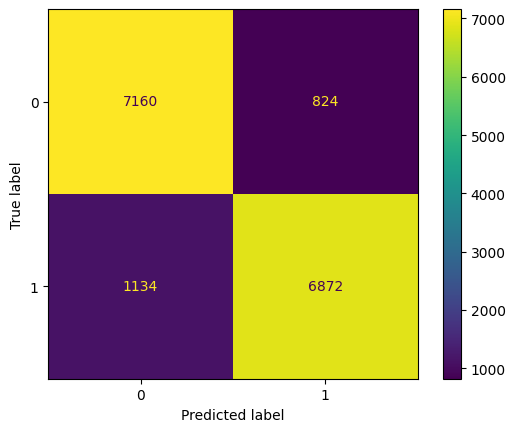

In [20]:
cm_test = confusion_matrix(y_test, y_pred, labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp.plot()
plt.show()

In [21]:
# Saving best linear model
with open("logistic_regression_best.pkl", "wb") as f:
    pickle.dump(model, f)

**Surprisingly, chosing the best parameter doesn't work as well as a random model - 0.63 F score. This is highly unexpected.**

#### Neural Network Model

A simple Neural network with an activation function of ReLU is tested on the ROI vectors. The hope is that it performs better than the Simple Logistic Regression method. 

Process flow:

1. Split train set using 5 fold cross validation; we train different hyperparameters on 4 folds and test on the fold left out. The average accuracy across the different folds is taken as the final accuracy of the fold. 

2. Hyperparameters chosen: Batch Size, Learning Rate, Activation Function -- only if more than 1 layer, and model architecture. 

3. Since we are directly dealing with the feature vector, we don't use augmentations. We will later integrate this pipeline with Hitesh's and test. For now, this is what we are going with. 

4. Given the flexibility of ADAM, we are going to go with it for the optimizer; the loss function is simple Cross Entropy. 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.model_selection import KFold

In [3]:
# Running on Apple Silicon
DEVICE = "mps"
# Setting Global Seed for Reproducibility
SEED = 42
# Setting seed for MPS
if torch.backends.mps.is_available():
    torch.mps.manual_seed(SEED)
# Disable benchmarking for deterministic behavior
torch.backends.cudnn.benchmark = False

In [4]:
# Dataset class for dataset
class RIO_dataset(Dataset):
    """
    Dataset class for RIO vector
    Initialized with X and Y numpy arrays. 
    """
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        # Self variables for X and Y
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()
        # assert 2D X variable and matching counts
        assert len(X.shape) == 2 and X.shape[0] == Y.shape[0], "X is not 2-dim or X and Y counts don't match"
        # Length variable
        self.length = X.shape[0]
    
    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Returns X and Y pertaining to index
        return self.X[idx, :], self.Y[idx]

In [5]:
class Net(nn.Module):
    """
    Neural Network class. Initialized with input dimension, classes and 
    a list of hidden dims, signifying the different layers. Weights initialized
    with Kaiming due to the use of GeLU
    """
    def __init__(self, input_dim: int, classes: int, hidden_dims: list, seed = SEED):
        super(Net, self).__init__()
        # Layers
        self.layers = nn.ModuleList()
        # Batch Norm Layers
        self.bn_layers = nn.ModuleList()
        # Setting Seed
        torch.manual_seed(seed)
        # Based on the input dim and hidden dims, create neural net with layers
        for i in range(len(hidden_dims)):
            if i == 0:
                layer = nn.Linear(in_features=input_dim, out_features=hidden_dims[i])
            else:
                layer = nn.Linear(in_features=hidden_dims[i - 1], out_features=hidden_dims[i])
            
            # Initializing weights according to ReLU
            nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
            nn.init.constant_(layer.bias, 0)

            # Appending layer to ModuleList
            self.layers.append(layer)
            #Appending batch norm layer
            self.bn_layers.append(nn.BatchNorm1d(hidden_dims[i]))

        # Creating final classification layer
        self.classifier = nn.Linear(in_features=hidden_dims[-1], out_features=classes)
        # Initializing according to Xavier
        nn.init.xavier_uniform_(self.classifier.weight)
        nn.init.constant_(self.classifier.bias, 0)

    def forward(self, x):
        # Processing the input through the multiple layers
        for layer, bn in zip(self.layers, self.bn_layers):
            # Feedforward
            x = layer(x)
            # Batch norm
            x = bn(x)
            # ReLU activation
            x = F.relu(x)
        # Final classification
        logits = self.classifier(x)
        return logits




In [6]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device = DEVICE, epochs = 2):
    """
    Function to run training and validation
    Parameters:
        model: The pytorch model object
        train_loader: PyTorch dataloader corresponding to the training dataset
        val_loader: PyTorch dataloader corresponding to the validation dataset
        criterion: The PyTorch loss function
        optimizer: The PyTorch optimizer to use for weight update
        device: GPU Device
    Return:
        validation loss: The average of validation loss across validation set
    """
    model.train()
    # Training
    for i in range(epochs):
      for inputs, targets in train_loader:
          # Zero the gradients before forward pass
          optimizer.zero_grad()
          inputs = inputs.to(DEVICE)
          targets = targets.to(DEVICE)
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          # Backpropagation
          loss.backward()
          optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    # Not returning the model as the weights are updated inside the model class
    return val_loss / len(val_loader)

# Main function for cross-validation
def cross_validate(trainset, input_size, batch_sizes, hidden_layers, seed = SEED, device = DEVICE):
    """
    Function to run cross validation
    Parameters:
        trainset: The training dataset object
        batch_size: List of all the batch_sizes for cross validation
        hidden_layers: List of hidden layer configurations
        seed: The seed
        device: GPU device
    Returns:
        loss_results: Dictionary containing the parameters tested and the respective 5-fold validation loss
    """
    # 5 fold cross validation
    kfold = KFold(n_splits=5, shuffle = True, random_state = 42)
    #Storing results
    loss_results = {}
    # Iterating through all batch sizes and hidden layer configurations
    for batch_size in batch_sizes:
        for hidden_layer in hidden_layers:
            # List for keeping track of loss per fold
            fold_loss = []
            # Splitting dataset based on Kfold
            for train_idx, val_idx in kfold.split(trainset):
                train_subset = torch.utils.data.Subset(trainset, train_idx)
                val_subset = torch.utils.data.Subset(trainset, val_idx)
                # Dataloader Creation with new train and val
                # Batch size is utilized here
                train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers = 0, drop_last = True, generator = torch.Generator().manual_seed(seed))
                val_loader = DataLoader(val_subset, batch_size=1, shuffle = False, num_workers = 0)
                # Initializing model
                model = Net(input_dim = input_size, classes = 2, hidden_dims=hidden_layer)
                model.to(DEVICE)
                # Model training parameters
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=0.001)
                # Obtaining validation loss for this fold
                val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device = device)
                fold_loss.append(val_loss)
            # Averaging loss across the folds
            avg_loss = sum(fold_loss) / len(fold_loss)
            string = "Batch Size: " + str(batch_size) + "; MLP: {}".format(hidden_layer)
            loss_results[string] = avg_loss
            print(string + " : ", avg_loss)

    return loss_results


In [7]:
# Path to the dataset
PATH = "/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/"

In [8]:
# Loading the X and Y
X = np.load("X_complete.npy")
import pandas as pd
Y = pd.read_csv(os.path.join(PATH, "train.csv"))["label"].to_numpy()
print("Shapes of Features {}; Shape of GT {}".format(X.shape, Y.shape))

Shapes of Features (79950, 49); Shape of GT (79950,)


In [9]:
# Loading the dataset
train_dataset = RIO_dataset(X = X, Y = Y)

**If model weights are initialized properly, loss should be around 0.69 -- log(0.5)**

In [ ]:
# Initializing Model and storing it in device
model = Net(input_dim = 49, classes = 2, hidden_dims = [25])
model.to(DEVICE)
# Loss function
criterion = nn.CrossEntropyLoss()
# Dataloader
demo_loader = DataLoader(train_dataset, batch_size = 2, shuffle = False)
# Testing Loss
for inputs, targets in demo_loader:
    input_tensor = inputs.to(DEVICE)
    targets = targets.to(DEVICE)
    output_t = model(input_tensor)
    loss = criterion(output_t, targets)
    print("LOSS: ", loss.item())
    break
    

LOSS:  0.6754806041717529


**The model is initialized properly**

In [9]:
# Hyperparameter options
batch_sizes = [32, 64, 128]
# 3 Different depths of layers
hidden_layers = [[25],[25, 12], [25, 12, 6]]

In [10]:
INPUT_SIZE  = 49
# Running Cross Validation
cross_validate(trainset = train_dataset, input_size = INPUT_SIZE, batch_sizes = batch_sizes, hidden_layers = hidden_layers)

Batch Size: 32; MLP: [25] :  0.3253409331254043
Batch Size: 32; MLP: [25, 12] :  0.32316558755894237
Batch Size: 32; MLP: [25, 12, 6] :  0.31944671310620193
Batch Size: 64; MLP: [25] :  0.3292680589079756
Batch Size: 64; MLP: [25, 12] :  0.3164450147421599
Batch Size: 64; MLP: [25, 12, 6] :  0.33000566978870405
Batch Size: 128; MLP: [25] :  0.3290186554730033
Batch Size: 128; MLP: [25, 12] :  0.32927811060951323
Batch Size: 128; MLP: [25, 12, 6] :  0.3211062512282809


{'Batch Size: 32; MLP: [25]': 0.3253409331254043,
 'Batch Size: 32; MLP: [25, 12]': 0.32316558755894237,
 'Batch Size: 32; MLP: [25, 12, 6]': 0.31944671310620193,
 'Batch Size: 64; MLP: [25]': 0.3292680589079756,
 'Batch Size: 64; MLP: [25, 12]': 0.3164450147421599,
 'Batch Size: 64; MLP: [25, 12, 6]': 0.33000566978870405,
 'Batch Size: 128; MLP: [25]': 0.3290186554730033,
 'Batch Size: 128; MLP: [25, 12]': 0.32927811060951323,
 'Batch Size: 128; MLP: [25, 12, 6]': 0.3211062512282809}

**It looks like bigger batch sizes - [1200, 3600, 7200] -  are a bad idea. In this run, its clear than a batch size of 64 along with an MLP architecture of [25, 12] works the best -- albeit by almost nothing**

##### Training with Selected Parameters

In [23]:
# Selected model architecture: 
model = Net(input_dim = 49, classes = 2, hidden_dims = [25, 12])
model.to(DEVICE)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=49, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=12, bias=True)
  )
  (bn_layers): ModuleList(
    (0): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)

In [24]:
# Splitting dataset into train and val
trainset = torch.utils.data.Subset(train_dataset, [i for i in range(69950)])
valset = torch.utils.data.Subset(train_dataset, [i for i in range(69950, 79950)])

In [25]:
# Dataloader with selected batch size
trainloader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, drop_last = True, generator = torch.Generator().manual_seed(SEED))
valloader = DataLoader(valset, batch_size = 1, shuffle = False, num_workers = 0)

In [26]:
# Setting loss and optimizer and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
# Parameters for cosine scheduling
MAX_EPOCHS = 30
eta_min = 1e-6 # Minimum learning rate
# Cosine scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = MAX_EPOCHS, eta_min = eta_min)

During training, we will aim to track 3 different things:

1. Training Loss

2. Validation Loss

3. Learning Rate - since we using a scheduler

In [27]:
# dictionary for capture
NN_dict = {"Training Loss" : [], "Validation Loss" : [], "Learning Rate" : []}

In [28]:
# Training
for i in range(MAX_EPOCHS):
    training_loss = 0.0
    model.train()
    for inputs, targets in trainloader:
        # Zero the gradients before forward pass
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        training_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
    # Adding average training loss in epoch
    average_training_loss = training_loss / len(trainloader)
    NN_dict["Training Loss"].append(average_training_loss)
    # Capturing Learning Rate
    NN_dict["Learning Rate"].append(scheduler.get_last_lr()[0])
    # Scheduler step every epoch
    scheduler.step()


    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in valloader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    # Not returning the model as the weights are updated inside the model class
    average_validation_loss =  val_loss / len(valloader)
    NN_dict["Validation Loss"].append(average_validation_loss)
    print("EPOCH {}: TRAINING LOSS = {}; VALIDATION LOSS = {}".format(i, average_training_loss, average_validation_loss))

EPOCH 0: TRAINING LOSS = 0.36621658055064005; VALIDATION LOSS = 0.33964735554151515
EPOCH 1: TRAINING LOSS = 0.31923964997623866; VALIDATION LOSS = 0.3060968347838656
EPOCH 2: TRAINING LOSS = 0.30446448089766415; VALIDATION LOSS = 0.2970727629220993
EPOCH 3: TRAINING LOSS = 0.29495021006290295; VALIDATION LOSS = 0.2998035261732288
EPOCH 4: TRAINING LOSS = 0.2857312440544694; VALIDATION LOSS = 0.307981526207067
EPOCH 5: TRAINING LOSS = 0.2801593976579743; VALIDATION LOSS = 0.2869174355252967
EPOCH 6: TRAINING LOSS = 0.27463218470141565; VALIDATION LOSS = 0.2673369343336981
EPOCH 7: TRAINING LOSS = 0.27132176991292845; VALIDATION LOSS = 0.29822134846542686
EPOCH 8: TRAINING LOSS = 0.2691353072545358; VALIDATION LOSS = 0.2609106285233201
EPOCH 9: TRAINING LOSS = 0.26561072577923645; VALIDATION LOSS = 0.26598172212630233
EPOCH 10: TRAINING LOSS = 0.26335883103720437; VALIDATION LOSS = 0.2934061939049167
EPOCH 11: TRAINING LOSS = 0.26096437262855604; VALIDATION LOSS = 0.31465793405542747
EP

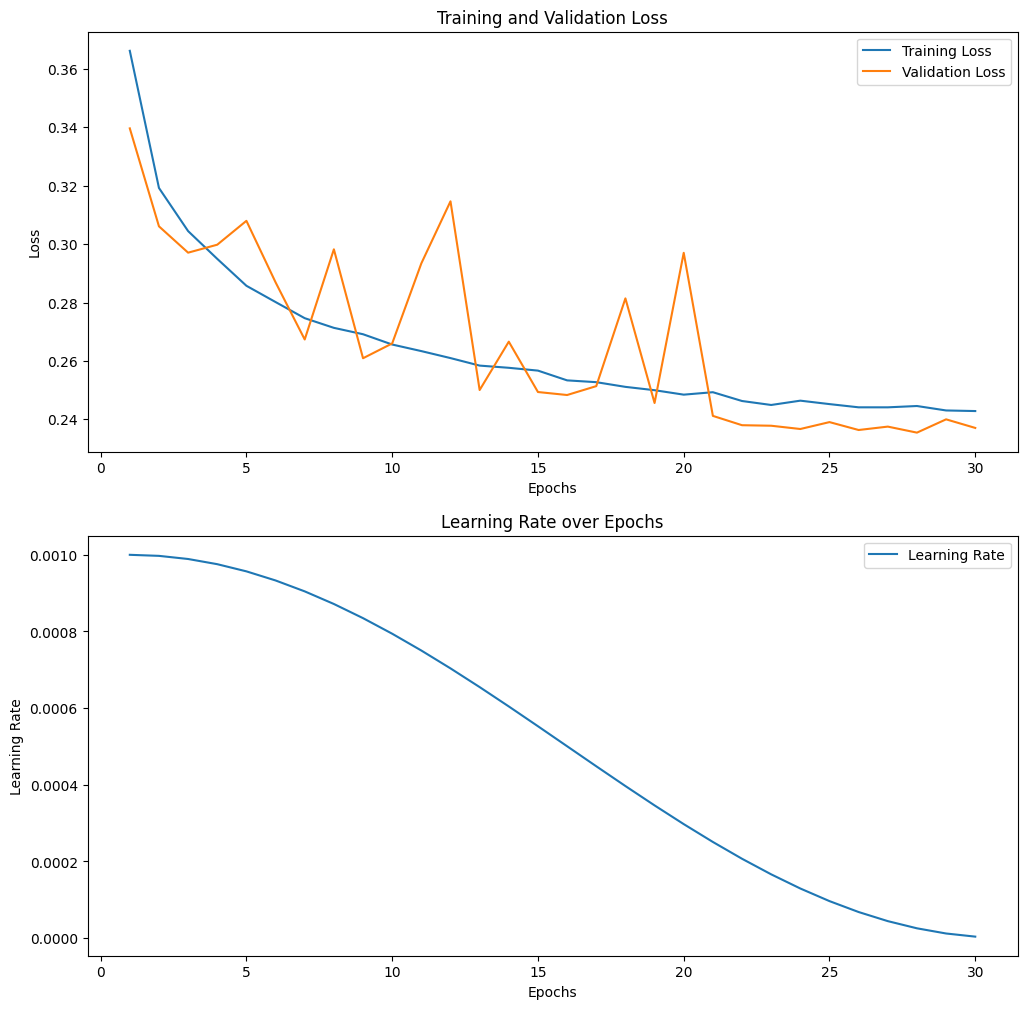

In [29]:
import matplotlib.pyplot as plt

# Assuming NN_dict is your dictionary with the stored data
epochs = range(1, len(NN_dict["Training Loss"]) + 1)

plt.figure(figsize=(12, 12))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, NN_dict["Training Loss"], label='Training Loss')
plt.plot(epochs, NN_dict["Validation Loss"], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Learning Rate
plt.subplot(2, 1, 2)
plt.plot(epochs, NN_dict["Learning Rate"], label='Learning Rate')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()


##### Predicting on the test set -- the same used for Logistic Regression

In [30]:
# Recreating the testset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
test_dataset = RIO_dataset(X = X_test, Y = y_test)
testloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers = 0)


In [31]:
# Setting model in val mode
model.eval()
prediction = []

with torch.no_grad():
    for inputs, targets in testloader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = model(inputs)
        # probabilities
        prob = torch.sigmoid(outputs)
        predicted_class = torch.argmax(prob, dim = 1).item()
        prediction.append(predicted_class)

In [32]:
print("Accuracy on test set:", accuracy_score(y_test, prediction))

Accuracy on test set: 0.908317698561601


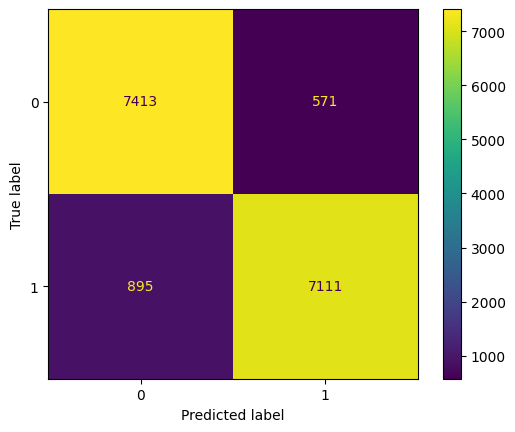

In [33]:
cm_test = confusion_matrix(y_test, prediction, labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0,1])
disp.plot()
plt.show()

In [34]:
torch.save(model, "FFN_1_layer")

#### RCI vector robustness testing

The goal of this experiment is simple: We take 10 images at random; then, we compare the RIO vector with the vector from the resized version of the same image and a vector from the other 9 random images. The goal is to see if the Feature Vector is invariant to image resolution.

In [13]:
import random
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [14]:
def feature_matrix_creator(paths: list, dim = 49, resize = False, resize_tuple = (400, 400)):
    """
    Create feature matrix from list of image paths

    Parameters:
        paths: List of paths
        dim: Dimension of RIO vector

    Returns:
        feature_matrix: Numpy feature matrix
    """
    feature_matrix = np.zeros((len(paths), dim))
    print("Shape of Feature Matrix: ", feature_matrix.shape)
    # Creating feature matrix:
    for i in range(len(paths)):
        img = Image.open(paths[i])
        # If resize is True
        if resize:
            image = Image.open(i).resize(resize_tuple)
        fft = fft_ybr(image = np.array(img), channel = "Y")
        rio = rio_fft(fft, "linear")
        feature_matrix[i, :] = rio
    return feature_matrix



In [15]:
# Loading random Images
path = "/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data"
trainset = os.listdir(path)
print("Number of training images: ", len(trainset))


Number of training images:  79950


In [16]:
# 10 random images
random_indices = [random.randint(0, len(trainset)) for _ in range(10)]
paths = [os.path.join(path, trainset[i]) for i in random_indices]
print(paths)

['/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/3aa8019161bf48ec8757cee842d1b437.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/e24af31ec7cf4cf2ac5c0276b0bfdd84.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/3e3822a73b2d4efdaa0bab2a1c14e150.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/3551448710cd4dc48c0a7ecb8124c25d.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/b3695900992c4edbb1133bc93fd89b8c.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/1cf159fdef284a60933a123aeea5a20a.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/596da3a42d044356b41af83b6e6390ea.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/5ed1b0634e0449ababe96ecfd2bb2896.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/eaf53f131a0d453da98d6d1f4a2507c4.jpg', '/Users/ashwathsreeram/Desktop/ML_Kaggle/archive/train_data/46878c5009fd4c7eb4bd422007586d7b.jpg']


In [17]:
rio_matrix = feature_matrix_creator(paths)
rio_matrix_resize = feature_matrix_creator(paths, dim = 49, resize = False)


Shape of Feature Matrix:  (10, 49)
Shape of Feature Matrix:  (10, 49)


DISTANCE MATRIX:


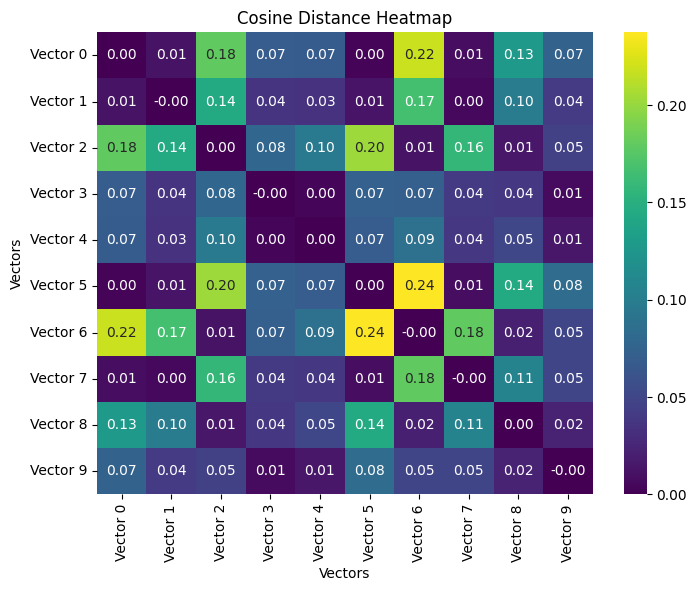

In [22]:
# Calculating cosine distance -- between resized and original
distance = 1 - cosine_similarity(rio_matrix, rio_matrix_resize)
print("DISTANCE MATRIX:")
plt.figure(figsize=(8, 6))
sns.heatmap(distance, cmap='viridis', annot=True, fmt=".2f", 
            xticklabels=[f'Vector {i}' for i in range(len(distance))],
            yticklabels=[f'Vector {i}' for i in range(len(distance))],
            vmin = np.min(distance), vmax = np.max(distance))
plt.title('Cosine Distance Heatmap')
plt.xlabel('Vectors')
plt.ylabel('Vectors')
plt.show()


DISTANCE MATRIX:


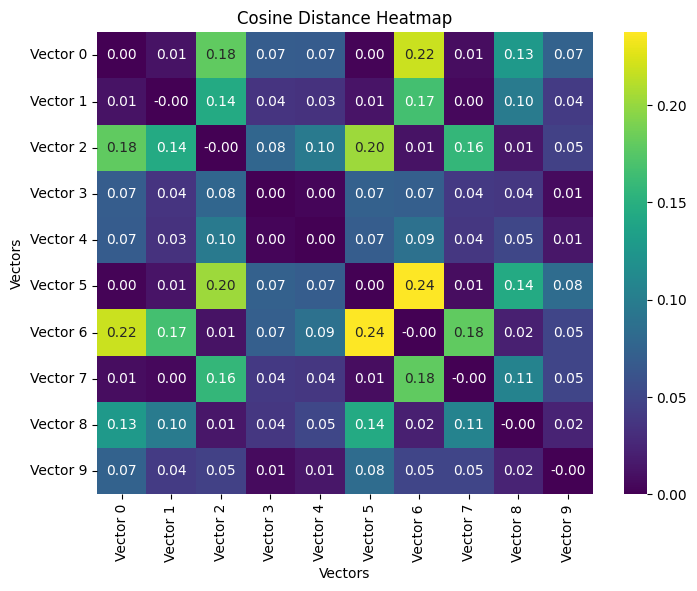

In [23]:
# Calculating cosine distance -- between original and original
distance = 1 - cosine_similarity(rio_matrix, rio_matrix)
print("DISTANCE MATRIX:")
plt.figure(figsize=(8, 6))
sns.heatmap(distance, cmap='viridis', annot=True, fmt=".2f", 
            xticklabels=[f'Vector {i}' for i in range(len(distance))],
            yticklabels=[f'Vector {i}' for i in range(len(distance))],
            vmin = np.min(distance), vmax = np.max(distance))
plt.title('Cosine Distance Heatmap')
plt.xlabel('Vectors')
plt.ylabel('Vectors')
plt.show()


**From the matrices it is clear that the feature matrix we are doing does a great job of being agnostic to resizing.**